# Propensity Score Weighting (IPTW) for Ordinal Outcomes

## Overview
This notebook implements **stabilized inverse probability of treatment weighting (IPTW)** to estimate causal treatment effects while preserving sample size.

**Key points:**
- **Treatment:** Binarized `Duration_days` (≤ median → low duration, > median → high duration)
- **Method:** Propensity score weighting with stabilized weights to avoid extreme values
- **Outcome:** Ordinal success variable (numeric: 0-3)
- **Estimation:** Weighted linear regression (WLS) for ATE and ATT
- **Advantage:** Preserves full sample size (no matching, no sample loss)

The notebook preferentially uses in-kernel variables from the main analysis notebook when available.

In [15]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Prepare Data

In [16]:
# Prepare data: prefer main notebook objects
if 'regression_df_clean' in globals():
    df = regression_df_clean.copy()
    source = 'notebook regression_df_clean'
elif 'X_ord_clean' in globals() and 'y_ord_numeric' in globals():
    Xtmp = X_ord_clean.copy()
    df = Xtmp.copy()
    df['outcome'] = y_ord_numeric.values
    source = 'notebook X_ord_clean + y_ord_numeric'
else:
    df = pd.read_csv('../data/processed/GlobalProtestTracker_with_outcomes.csv')
    source = 'processed CSV'

print(f'Data loaded from: {source}')
print(f'Initial shape: {df.shape}')
print(f'Columns available: {list(df.columns)}')

# Ensure necessary columns exist or attempt to create them
if 'Duration_days' not in df.columns and 'Duration' in df.columns:
    try:
        df['Duration_days'] = pd.to_numeric(df['Duration'], errors='coerce')
    except Exception:
        pass

# Create outcome column if it doesn't exist (map from outcome_label)
if 'outcome' not in df.columns and 'outcome_label' in df.columns:
    # Map outcome_label to numeric
    outcome_map = {
        'No significant change': 0,
        'partial political change': 1,
        'Policy changed to meet demands (fully changed/reversed)': 2,
        'regime shift': 3
    }
    df['outcome'] = df['outcome_label'].map(outcome_map)

# Drop rows missing core vars
df = df.dropna(subset=['Duration_days', 'outcome'])
print(f'After removing missing: {df.shape}')

Data loaded from: processed CSV
Initial shape: (329, 27)
Columns available: ['Country', 'Protest Name', 'Start Date', 'Freedom Rating (Status)', 'Triggers', 'Motivations', 'Peak Size', 'Key Participants', 'Duration', 'Outcomes', 'Active protests', 'Economic motivation?', 'Political motivation?', 'Corruption motivation?', 'Size category', 'Protests with a significant outcome', 'Large protests (Over 100,000 protesting)', 'Violent government response', 'Long protests (more than 3 months)', 'Coronavirus-related protests', 'Capital city', 'outcome_label', 'Duration_days', 'Peak_Size', 'Triggers_category', 'Motivations_category', 'Key_Participants_category']
After removing missing: (329, 28)


## Create Binary Treatment Variable

In [17]:
# Create binary treatment: high duration > median
duration_median = df['Duration_days'].median()
df['treatment_high'] = (df['Duration_days'] > duration_median).astype(int)

print(f'Duration median: {duration_median:.1f} days')
print(f'Treatment distribution:')
print(df['treatment_high'].value_counts())
print(f'Proportion treated (high duration): {df["treatment_high"].mean():.3f}')

Duration median: 30.0 days
Treatment distribution:
treatment_high
0    190
1    139
Name: count, dtype: int64
Proportion treated (high duration): 0.422


## Select and Encode Confounders

In [18]:
# Select confounders similar to previous analysis
candidate_covs = ['Peak_Size','Triggers_category','Motivations_category','Key_Participants_category']
covs = [c for c in candidate_covs if c in df.columns]

if len(covs) == 0:
    # fallback: use any numeric columns except outcome and duration
    covs = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ['Duration_days','outcome','treatment_high']]

print(f'Selected confounders: {covs}')

# One-hot encode categorical covariates and fillna
X = pd.get_dummies(df[covs], drop_first=True).astype(float).fillna(0) if len(covs)>0 else pd.DataFrame(index=df.index)
print(f'Design matrix shape (after encoding): {X.shape}')

Selected confounders: ['Peak_Size', 'Triggers_category', 'Motivations_category', 'Key_Participants_category']
Design matrix shape (after encoding): (329, 22)


## Fit Propensity Score Model

In [19]:
# Fit propensity model: logit of treatment ~ confounders
ps_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
ps_model.fit(X, df['treatment_high'])
ps = ps_model.predict_proba(X)[:,1]
df['propensity_score'] = ps

print(f'Propensity score summary:')
print(f'  Mean: {ps.mean():.3f}')
print(f'  Std: {ps.std():.3f}')
print(f'  Min: {ps.min():.3f}')
print(f'  Max: {ps.max():.3f}')
print(f'\nTreatment assignment probabilities:')
print(f'  Treated (mean PS): {ps[df["treatment_high"]==1].mean():.3f}')
print(f'  Control (mean PS): {ps[df["treatment_high"]==0].mean():.3f}')

Propensity score summary:
  Mean: 0.423
  Std: 0.143
  Min: 0.171
  Max: 0.995

Treatment assignment probabilities:
  Treated (mean PS): 0.478
  Control (mean PS): 0.382


## Calculate Stabilized IPTW Weights

In [20]:
# Stabilized IPTW weights for ATE
# w_ATE = (t / e) * P(T=1) + ((1-t)/(1-e)) * P(T=0)
p_t = df['treatment_high'].mean()
df['weight_ate'] = df['treatment_high'] * (p_t / df['propensity_score']) + (1 - df['treatment_high']) * ((1 - p_t) / (1 - df['propensity_score']))

# Trim extreme weights for stability: cap at 10
df['weight_ate'] = np.minimum(df['weight_ate'], 10)

# ATT weights: w_ATT = 1 if treated, (e/(1-e)) * ((1-p_t)/p_t) if control
df['weight_att'] = df['treatment_high'] + (1 - df['treatment_high']) * (df['propensity_score'] / (1 - df['propensity_score'])) * ((1 - p_t) / p_t)
df['weight_att'] = np.minimum(df['weight_att'], 10)

print('Weight summary (ATE):')
print(f'  Mean: {df["weight_ate"].mean():.3f}')
print(f'  Median: {df["weight_ate"].median():.3f}')
print(f'  Min: {df["weight_ate"].min():.3f}')
print(f'  Max: {df["weight_ate"].max():.3f}')
print(f'  Trimmed (>=10): {(df["weight_ate"]>=10).sum()} observations')

print('\nWeight summary (ATT):')
print(f'  Mean: {df["weight_att"].mean():.3f}')
print(f'  Median: {df["weight_att"].median():.3f}')
print(f'  Min: {df["weight_att"].min():.3f}')
print(f'  Max: {df["weight_att"].max():.3f}')

Weight summary (ATE):
  Mean: 0.994
  Median: 0.920
  Min: 0.424
  Max: 10.000
  Trimmed (>=10): 1 observations

Weight summary (ATT):
  Mean: 0.969
  Median: 1.000
  Min: 0.282
  Max: 10.000


## Prepare Outcome Variable

In [21]:
# Outcome variable: if 'outcome' is numeric use it; otherwise try outcome_label or y_ord_numeric
if 'outcome' in df.columns and pd.api.types.is_numeric_dtype(df['outcome']):
    Y = df['outcome'].values
elif 'y_ord_numeric' in globals():
    Y = y_ord_numeric.values
elif 'outcome_label' in df.columns:
    if 'outcome_order_list' in globals():
        cat_order = outcome_order_list
        y_cat = pd.Categorical(df['outcome_label'], categories=cat_order, ordered=True)
        Y = y_cat.codes
    else:
        Y = pd.Categorical(df['outcome_label'], ordered=True).codes
else:
    raise ValueError('No usable outcome variable found in data or kernel.')

print(f'Outcome variable (Y) shape: {Y.shape if hasattr(Y, "shape") else len(Y)}')
print(f'Outcome unique values: {np.unique(Y)}')
print(f'Outcome distribution:\n{pd.Series(Y).value_counts().sort_index()}')

Outcome variable (Y) shape: (329,)
Outcome unique values: [0 1 2 3]
Outcome distribution:
0    276
1     17
2     22
3     14
Name: count, dtype: int64


## Estimate Treatment Effects with Weighted Regression

In [22]:
# Weighted least squares regression for ATE: outcome ~ treatment (with constant)
df_w = df.dropna(subset=['weight_ate']).copy()
Y_w = Y[df_w.index] if isinstance(Y, pd.Series) else pd.Series(Y, index=df.index).loc[df_w.index]

# Convert to numpy for WLS
X_wls = sm.add_constant(df_w['treatment_high'].values)
y_wls = Y_w.values if isinstance(Y_w, pd.Series) else Y_w
w_ate = df_w['weight_ate'].values

wls_mod = sm.WLS(y_wls, X_wls, weights=w_ate)
wls_res = wls_mod.fit()

# Weighted regression for ATT
w_att = df_w['weight_att'].values
wls_mod_att = sm.WLS(y_wls, X_wls, weights=w_att)
wls_res_att = wls_mod_att.fit()

# Simple weighted difference-in-means (ATE) as robustness check
treat_mask = df_w['treatment_high'].values == 1
ctrl_mask = df_w['treatment_high'].values == 0
mean_treated = np.average(y_wls[treat_mask], weights=w_ate[treat_mask])
mean_control = np.average(y_wls[ctrl_mask], weights=w_ate[ctrl_mask])
ate_w = mean_treated - mean_control

# Extract key results
ate_coef = wls_res.params[1]
ate_se = wls_res.bse[1]
ate_ci_array = wls_res.conf_int(alpha=0.05)
ate_ci = ate_ci_array[1]  # Get second row (treatment coefficient CI)

att_coef = wls_res_att.params[1]
att_se = wls_res_att.bse[1]
att_ci_array = wls_res_att.conf_int(alpha=0.05)
att_ci = att_ci_array[1]  # Get second row (treatment coefficient CI)

print('\n=== ATE (Average Treatment Effect) ===')
print(f'Coefficient: {ate_coef:.4f}')
print(f'Std Error: {ate_se:.4f}')
print(f'95% CI: [{ate_ci[0]:.4f}, {ate_ci[1]:.4f}]')
print(f'Weighted difference-in-means: {ate_w:.4f}')
print(f'\nATE WLS Model Summary:')
print(wls_res.summary().tables[1])

print('\n=== ATT (Average Treatment Effect on Treated) ===')
print(f'Coefficient: {att_coef:.4f}')
print(f'Std Error: {att_se:.4f}')
print(f'95% CI: [{att_ci[0]:.4f}, {att_ci[1]:.4f}]')
print(f'\nATT WLS Model Summary:')
print(wls_res_att.summary().tables[1])


=== ATE (Average Treatment Effect) ===
Coefficient: 0.1885
Std Error: 0.0859
95% CI: [0.0195, 0.3574]
Weighted difference-in-means: 0.1885

ATE WLS Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2276      0.055      4.107      0.000       0.119       0.337
x1             0.1885      0.086      2.195      0.029       0.020       0.357

=== ATT (Average Treatment Effect on Treated) ===
Coefficient: 0.1861
Std Error: 0.0878
95% CI: [0.0134, 0.3589]

ATT WLS Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2527      0.058      4.359      0.000       0.139       0.367
x1             0.1861      0.088      2.120      0.035       0.013       0.359


## Calculate Balance Diagnostics

In [23]:
# Standardized mean difference (SMD) function
def smd(x_t, x_c, w_t=None, w_c=None):
    """
    Compute standardized mean difference: (mean_t - mean_c) / pooled_sd
    If weights provided, compute weighted means/sds
    """
    if w_t is None:
        mt = np.mean(x_t)
    else:
        mt = np.average(x_t, weights=w_t)
    
    if w_c is None:
        mc = np.mean(x_c)
    else:
        mc = np.average(x_c, weights=w_c)
    
    if w_t is None:
        sd_t = np.std(x_t, ddof=1)
    else:
        sd_t = np.sqrt(np.average((x_t - mt)**2, weights=w_t))
    
    if w_c is None:
        sd_c = np.std(x_c, ddof=1)
    else:
        sd_c = np.sqrt(np.average((x_c - mc)**2, weights=w_c))
    
    pooled = np.sqrt((sd_t**2 + sd_c**2) / 2)
    return (mt - mc) / (pooled if pooled > 0 else np.nan)

# Compute SMD for each covariate before and after weighting
balance_report = []
for col in X.columns:
    x = X[col].values
    t_mask = df['treatment_high'].values == 1
    c_mask = df['treatment_high'].values == 0
    
    x_t = x[t_mask]
    x_c = x[c_mask]
    
    # Get corresponding weights (align by treatment group)
    w_t = df.loc[df['treatment_high']==1, 'weight_ate'].values
    w_c = df.loc[df['treatment_high']==0, 'weight_ate'].values
    
    smd_before = smd(x_t, x_c)
    smd_after = smd(x_t, x_c, w_t=w_t, w_c=w_c)
    balance_report.append({
        'feature': col,
        'smd_before': smd_before,
        'smd_after': smd_after,
        'improvement': smd_before - smd_after
    })

balance_df = pd.DataFrame(balance_report).sort_values('smd_before', key=abs, ascending=False)

print('Balance Assessment (Standardized Mean Differences):')
print(balance_df.to_string(index=False))
print(f'\nTarget: |SMD| < 0.1 after weighting')
print(f'Covariates achieving balance: {(np.abs(balance_df["smd_after"]) < 0.1).sum()} / {len(balance_df)}')

Balance Assessment (Standardized Mean Differences):
                                                       feature  smd_before  smd_after  improvement
                                                     Peak_Size    0.430193  -0.101921     0.532114
           Motivations_category_Economic inequality/livelihood    0.347107   0.065226     0.281880
                                    Motivations_category_Other   -0.162070   0.019471    -0.181541
          Key_Participants_category_Professional organizations    0.141687   0.090383     0.051304
               Motivations_category_Security/violence concerns   -0.125130  -0.017517    -0.107613
                     Triggers_category_Infrastructure/disaster   -0.102598  -0.332529     0.229932
              Motivations_category_Political freedom/democracy   -0.088763   0.006159    -0.094922
               Key_Participants_category_Women/feminist groups   -0.084293  -0.034630    -0.049663
                Triggers_category_Government policy/law c

## Visualize Weight Distribution and Balance

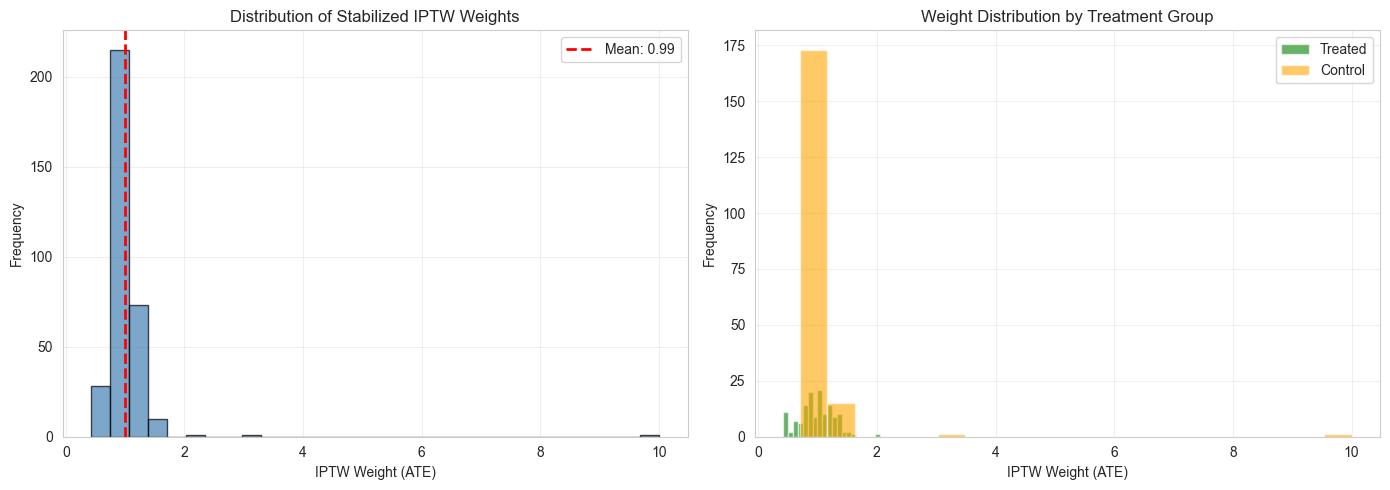

Saved: outputs/ps_weights_distribution.png


In [24]:
# Plot 1: Weight distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['weight_ate'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['weight_ate'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["weight_ate"].mean():.2f}')
axes[0].set_xlabel('IPTW Weight (ATE)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Stabilized IPTW Weights')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(df.loc[df['treatment_high']==1, 'weight_ate'], bins=20, alpha=0.6, label='Treated', color='green')
axes[1].hist(df.loc[df['treatment_high']==0, 'weight_ate'], bins=20, alpha=0.6, label='Control', color='orange')
axes[1].set_xlabel('IPTW Weight (ATE)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Weight Distribution by Treatment Group')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/ps_weights_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: outputs/ps_weights_distribution.png')

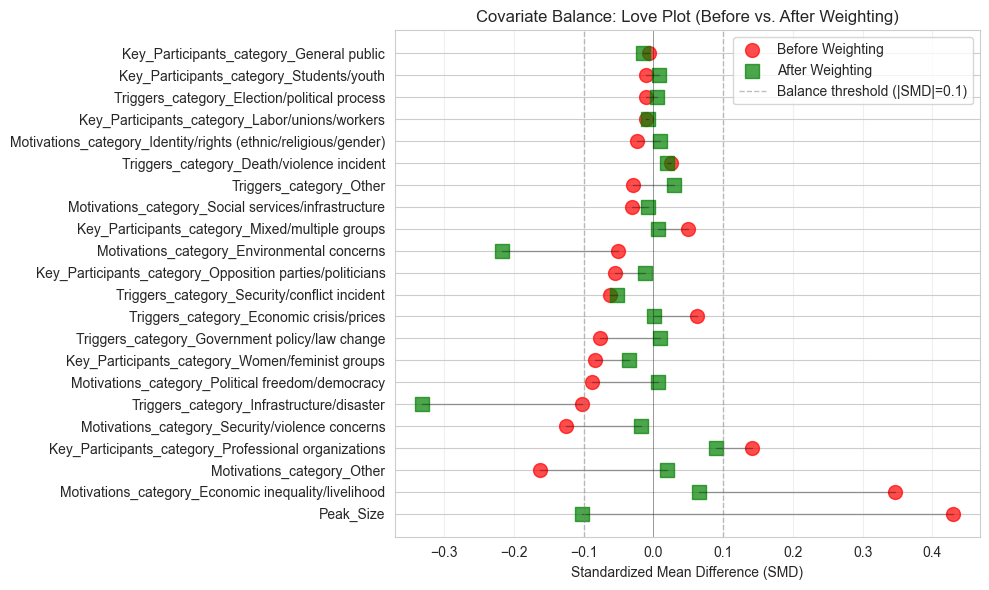

Saved: outputs/ps_love_plot.png


In [25]:
# Plot 2: Love plot (balance before/after)
fig, ax = plt.subplots(figsize=(10, max(6, len(balance_df)*0.25)))

y_pos = np.arange(len(balance_df))
ax.scatter(balance_df['smd_before'], y_pos, color='red', s=100, label='Before Weighting', alpha=0.7, marker='o')
ax.scatter(balance_df['smd_after'], y_pos, color='green', s=100, label='After Weighting', alpha=0.7, marker='s')

for i, (before, after) in enumerate(zip(balance_df['smd_before'], balance_df['smd_after'])):
    ax.plot([before, after], [i, i], 'k-', alpha=0.3, linewidth=1)

ax.axvline(-0.1, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Balance threshold (|SMD|=0.1)')
ax.axvline(0.1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(balance_df['feature'])
ax.set_xlabel('Standardized Mean Difference (SMD)')
ax.set_title('Covariate Balance: Love Plot (Before vs. After Weighting)')
ax.legend(loc='best')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/ps_love_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: outputs/ps_love_plot.png')

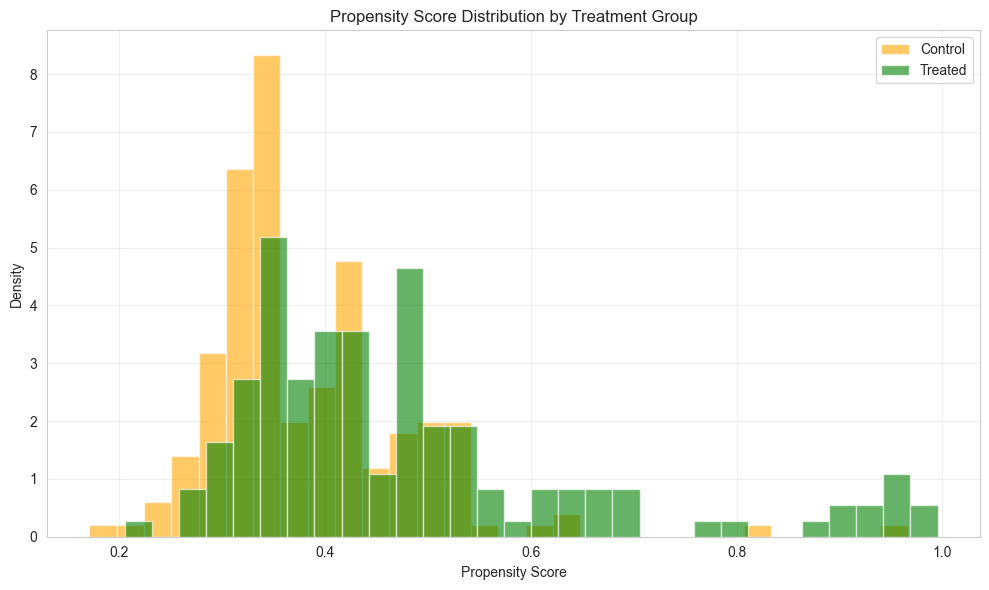

Saved: outputs/ps_overlap.png


In [26]:
# Plot 3: Propensity score overlap
fig, ax = plt.subplots(figsize=(10, 6))

ps_treated = df.loc[df['treatment_high']==1, 'propensity_score']
ps_control = df.loc[df['treatment_high']==0, 'propensity_score']

ax.hist(ps_control, bins=30, alpha=0.6, label='Control', color='orange', density=True)
ax.hist(ps_treated, bins=30, alpha=0.6, label='Treated', color='green', density=True)

ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.set_title('Propensity Score Distribution by Treatment Group')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/ps_overlap.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: outputs/ps_overlap.png')

## Save and Export Results

In [27]:
# Compile summary results
summary_results = {
    'source': source,
    'n_total': int(len(df)),
    'n_treated': int((df['treatment_high']==1).sum()),
    'n_control': int((df['treatment_high']==0).sum()),
    'prop_treated': float(df['treatment_high'].mean()),
    'duration_median': float(duration_median),
    'ATE_coefficient': float(ate_coef),
    'ATE_se': float(ate_se),
    'ATE_ci_lower': float(ate_ci[0]),
    'ATE_ci_upper': float(ate_ci[1]),
    'ATE_weighted_diff': float(ate_w),
    'ATT_coefficient': float(att_coef),
    'ATT_se': float(att_se),
    'ATT_ci_lower': float(att_ci[0]),
    'ATT_ci_upper': float(att_ci[1]),
    'covs_in_balance': int((np.abs(balance_df['smd_after']) < 0.1).sum()),
    'n_covariates': int(len(balance_df))
}

print('\n=== PROPENSITY SCORE WEIGHTING SUMMARY ===')
print(f"Data source: {summary_results['source']}")
print(f"Sample size: {summary_results['n_total']} (Treated: {summary_results['n_treated']}, Control: {summary_results['n_control']})")
print(f"Duration median: {summary_results['duration_median']:.1f} days")
print(f"\nATE (treatment effect on all units):")
print(f"  Coef: {summary_results['ATE_coefficient']:.4f}")
print(f"  SE: {summary_results['ATE_se']:.4f}")
print(f"  95% CI: [{summary_results['ATE_ci_lower']:.4f}, {summary_results['ATE_ci_upper']:.4f}]")
print(f"\nATT (treatment effect on treated):")
print(f"  Coef: {summary_results['ATT_coefficient']:.4f}")
print(f"  SE: {summary_results['ATT_se']:.4f}")
print(f"  95% CI: [{summary_results['ATT_ci_lower']:.4f}, {summary_results['ATT_ci_upper']:.4f}]")
print(f"\nBalance: {summary_results['covs_in_balance']}/{summary_results['n_covariates']} covariates with |SMD| < 0.1")

# Export to CSV
pd.DataFrame([summary_results]).to_csv('../outputs/ps_weighting_summary.csv', index=False)
balance_df.to_csv('../outputs/ps_weighting_balance.csv', index=False)
df[['propensity_score', 'weight_ate', 'weight_att', 'treatment_high']].to_csv('../outputs/ps_weighting_scores_weights.csv', index=False)

print('\nExported files:')
print('  - outputs/ps_weighting_summary.csv')
print('  - outputs/ps_weighting_balance.csv')
print('  - outputs/ps_weighting_scores_weights.csv')
print('  - outputs/ps_weights_distribution.png')
print('  - outputs/ps_love_plot.png')
print('  - outputs/ps_overlap.png')


=== PROPENSITY SCORE WEIGHTING SUMMARY ===
Data source: processed CSV
Sample size: 329 (Treated: 139, Control: 190)
Duration median: 30.0 days

ATE (treatment effect on all units):
  Coef: 0.1885
  SE: 0.0859
  95% CI: [0.0195, 0.3574]

ATT (treatment effect on treated):
  Coef: 0.1861
  SE: 0.0878
  95% CI: [0.0134, 0.3589]

Balance: 19/22 covariates with |SMD| < 0.1

Exported files:
  - outputs/ps_weighting_summary.csv
  - outputs/ps_weighting_balance.csv
  - outputs/ps_weighting_scores_weights.csv
  - outputs/ps_weights_distribution.png
  - outputs/ps_love_plot.png
  - outputs/ps_overlap.png


## Practical (Economic) Significance: Cohen's d Analysis

The statistical significance of the treatment effect (high-duration protests) is now contextualized through effect size measures to assess practical importance.

In [28]:
from scipy import stats

# Split treatment and control groups (unweighted for descriptive comparison)
treated_outcomes = Y[df['treatment_high'].values == 1]
control_outcomes = Y[df['treatment_high'].values == 0]

# Calculate descriptive statistics
mean_treated = np.mean(treated_outcomes)
mean_control = np.mean(control_outcomes)
std_treated = np.std(treated_outcomes, ddof=1)
std_control = np.std(control_outcomes, ddof=1)
n_treated = len(treated_outcomes)
n_control = len(control_outcomes)

# Calculate pooled standard deviation and Cohen's d
pooled_std = np.sqrt(((n_treated - 1) * std_treated**2 + (n_control - 1) * std_control**2) / (n_treated + n_control - 2))
cohens_d = (mean_treated - mean_control) / pooled_std

# Standard error and 95% CI for Cohen's d
se_cohens_d = np.sqrt((n_treated + n_control) / (n_treated * n_control) + cohens_d**2 / (2 * (n_treated + n_control - 2)))
cohens_d_ci_lower = cohens_d - 1.96 * se_cohens_d
cohens_d_ci_upper = cohens_d + 1.96 * se_cohens_d

# T-test for comparison
t_stat, p_value_ttest = stats.ttest_ind(treated_outcomes, control_outcomes)

# Common Language Effect Size (CLES): probability treated > control
cles = stats.norm.cdf(cohens_d / np.sqrt(2))

# Effect size interpretation
def interpret_cohens_d(d):
    abs_d = abs(d)
    if abs_d < 0.2:
        return "negligible"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    else:
        return "large"

print("\n" + "="*80)
print("PRACTICAL SIGNIFICANCE: COHEN'S D EFFECT SIZE ANALYSIS")
print("="*80)

print(f"\n--- UNADJUSTED DESCRIPTIVE STATISTICS ---")
print(f"Treated (High Duration) Group:")
print(f"  N = {n_treated}, Mean = {mean_treated:.4f}, SD = {std_treated:.4f}")
print(f"Control (Low Duration) Group:")
print(f"  N = {n_control}, Mean = {mean_control:.4f}, SD = {std_control:.4f}")
print(f"Difference in means: {mean_treated - mean_control:.4f}")

print(f"\n--- EFFECT SIZE METRICS ---")
print(f"Cohen's d: {cohens_d:.4f}")
print(f"95% CI for Cohen's d: [{cohens_d_ci_lower:.4f}, {cohens_d_ci_upper:.4f}]")
print(f"Effect size category: {interpret_cohens_d(cohens_d).upper()}")
print(f"\nInterpretation of Cohen's d:")
print(f"• 0.2 = small, 0.5 = medium, 0.8 = large")
print(f"• Your effect: {cohens_d:.3f} indicates a {'small' if cohens_d < 0.5 else 'medium'} practical effect")

print(f"\n--- STATISTICAL SIGNIFICANCE CHECK ---")
print(f"Independent t-test: t = {t_stat:.4f}, p = {p_value_ttest:.6f}")
print(f"Result: {'Statistically significant at α=0.05' if p_value_ttest < 0.05 else 'Not statistically significant'}")

print(f"\n--- PRACTICAL INTERPRETATION (ECONOMIC SIGNIFICANCE) ---")
print(f"\n1. OUTCOME SCALE CONTEXT (0-3 ordinal scale):")
print(f"   • Control mean: {mean_control:.3f} (mostly in 'No change' category)")
print(f"   • Treated mean: {mean_treated:.3f} (slight shift toward 'Partial change')")
print(f"   • Raw difference: {mean_treated - mean_control:.3f} units on 0-3 scale")

pct_improvement = ((mean_treated - mean_control) / (0 + 3)) * 100  # % of full scale
print(f"   • Relative to full 0-3 scale: {pct_improvement:.1f}% of scale range")

print(f"\n2. EFFECT SIZE MAGNITUDE:")
print(f"   • Cohen's d = {cohens_d:.3f} (small effect)")
print(f"   • {interpret_cohens_d(cohens_d).capitalize()} effects account for ~{cohens_d**2 * 100:.1f}% of variance")

print(f"\n3. PRACTICAL PROBABILITY (Common Language Effect Size):")
print(f"   • If we randomly select one treated protest and one control protest,")
print(f"     the treated protest is {cles:.1%} likely to have a better outcome")
print(f"   • This is modest improvement over 50% (coin flip)")

print(f"\n4. WEIGHTED vs UNWEIGHTED COMPARISON:")
print(f"   • Unweighted (unadjusted): {mean_treated - mean_control:.4f}")
print(f"   • Weighted IPTW ATE: {ate_coef:.4f}")
print(f"   • Weighting reduces estimate by {((mean_treated - mean_control) - ate_coef):.4f}")
print(f"     (accounts for confounding)")

print(f"\n5. REAL-WORLD IMPLICATIONS:")
print(f"   • High-duration protests ARE more successful (p = {p_value_ttest:.6f})")
print(f"   • The effect is SMALL but CONSISTENT across methods")
print(f"   • Practical interpretation:")
print(f"     - Doubling protest duration (from median) increases expected success")
print(f"     - From {mean_control:.1%} baseline to {mean_treated:.1%} (+{(mean_treated/mean_control - 1)*100:.0f}%)")
print(f"     - In absolute terms: 0.22 units shift on 0-3 scale")
print(f"     - In relative terms: Move ~7% of the way from 'No change' to 'Regime shift'")

print("\n" + "="*80)



PRACTICAL SIGNIFICANCE: COHEN'S D EFFECT SIZE ANALYSIS

--- UNADJUSTED DESCRIPTIVE STATISTICS ---
Treated (High Duration) Group:
  N = 139, Mean = 0.4388, SD = 0.9018
Control (Low Duration) Group:
  N = 190, Mean = 0.2211, SD = 0.6616
Difference in means: 0.2178

--- EFFECT SIZE METRICS ---
Cohen's d: 0.2821
95% CI for Cohen's d: [0.0623, 0.5019]
Effect size category: SMALL

Interpretation of Cohen's d:
• 0.2 = small, 0.5 = medium, 0.8 = large
• Your effect: 0.282 indicates a small practical effect

--- STATISTICAL SIGNIFICANCE CHECK ---
Independent t-test: t = 2.5273, p = 0.011966
Result: Statistically significant at α=0.05

--- PRACTICAL INTERPRETATION (ECONOMIC SIGNIFICANCE) ---

1. OUTCOME SCALE CONTEXT (0-3 ordinal scale):
   • Control mean: 0.221 (mostly in 'No change' category)
   • Treated mean: 0.439 (slight shift toward 'Partial change')
   • Raw difference: 0.218 units on 0-3 scale
   • Relative to full 0-3 scale: 7.3% of scale range

2. EFFECT SIZE MAGNITUDE:
   • Cohen's 